In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC, NuSVC
from sklearn.mixture import GaussianMixture
from sklearn import linear_model, ensemble
from scipy.signal import find_peaks_cwt
from FeatureAnalysis import RescalePCA, HistFeature
from DataProcessing import ToPythonData, CombineTrials, SubSampleData, AddNoise
import random

In [2]:
# convert all trial data and to be ready to pass in to the PCA 
gait_names = ['normal', # normal
             'fd',# foot drop
             'hem', #Hemiplegic Gait
             'injured']
# store all original data into a dictionary 
max_trials = 5
trials = {}
print('All Trials: ')
for each_gait in gait_names:
    for each_trial_num in range(1,max_trials + 1):
        cur_trial_name = each_gait + ('_0' if max_trials < 10 else '') + str(each_trial_num)
        trials[cur_trial_name] = ToPythonData('../Data_Collection/' + cur_trial_name + '.txt')
    print(each_gait + ': ' + str(list(range(1,max_trials + 1))))
all_trial_data = CombineTrials(trials)

All Trials: 
normal: [1, 2, 3, 4, 5]
fd: [1, 2, 3, 4, 5]
hem: [1, 2, 3, 4, 5]
injured: [1, 2, 3, 4, 5]


In [3]:
# concatenate all trials for a single tpye of gait in to a larger chuck 
# and subsmaple with noise add for data augumentation

# put all same type of trial into one list to prepare for data combination 
combined_trials = {}
for trial in trials:
    cur_type = trial[:trial.index('_')]
    if cur_type not in combined_trials: combined_trials[cur_type] = {trial:trials[trial]}
    else: combined_trials[cur_type][cur_type] = trials[trial]
        
for each_type in combined_trials:
    combined_trials[each_type] = CombineTrials(combined_trials[each_type])

In [4]:
num_sub_each_type = 150
len_sub_sample = 5000
all_aug_data = {}
for each_type in combined_trials:
    cur_aug_data = SubSampleData(combined_trials[each_type], len_sub_sample, num_sub_each_type)
    for idx in range(len(cur_aug_data)):
        all_aug_data[each_type + '_' + str(idx)] = AddNoise(cur_aug_data[idx])

dict_keys(['Gyro_y', 'Acc_z', 'Gyro_z', 'Voltage_02', 'Time', 'Voltage_01', 'Acc_x', 'Gyro_x', 'Acc_y'])


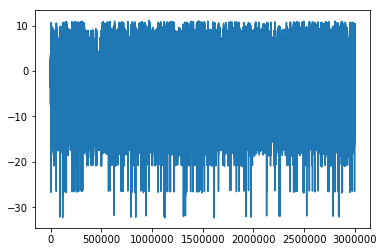

In [5]:
all_trial_data = CombineTrials(all_aug_data)
print(all_trial_data.keys())
plt.figure()
plt.plot(all_trial_data["Acc_x"])

In [12]:
PCA_all = RescalePCA()
PCA_all.processRescalePCA(CombineTrials(trials))
print(PCA_all)

PCA Info: 
[ 0.43926075  0.36644486  0.07950976]
Rescale Info:
Gyro_y: (4.2699999999999996, -4.2800000000000002)
Acc_z: (78.469999999999999, -22.219999999999999)
Gyro_z: (4.1799999999999997, -4.2800000000000002)
Voltage_02: (1.1200000000000001, -0.070000000000000007)
Voltage_01: (4.0, -0.070000000000000007)
Acc_x: (16.890000000000001, -42.229999999999997)
Gyro_x: (4.2800000000000002, -4.2800000000000002)
Acc_y: (36.189999999999998, -57.609999999999999)
Component Range: 
[-0.5  -0.5  -0.46]
[ 0.87  0.6   0.51]
Feature Order: No features are given


In [13]:
# combine all the trials data into HistFeatures and combined into a matrix for modeling training 
num_hist_fea_bins = 10
test_feature_mat = np.zeros((3 * num_hist_fea_bins,len(all_aug_data)))
actual_label = np.zeros(len(all_aug_data))

trials_list = list(all_aug_data.keys())
for idx in range(len(trials_list)):
    cur_trial_name = trials_list[idx]
    cur_data_dict = all_aug_data[cur_trial_name]
    cur_data_pca = PCA_all.applyRescalePCA(cur_data_dict)
    test_feature_mat[:,idx] = HistFeature(cur_data_pca, PCA_all.component_range, num_hist_fea_bins).T    
    cur_gait_name = cur_trial_name[:cur_trial_name.index('_')]
    actual_label[idx] = gait_names.index(cur_gait_name)
print(test_feature_mat.shape)

(30, 600)


In [173]:
# test case for testing models
test_case_name = 'normal_01'
test_case = ToPythonData('../Data_Collection/' + test_case_name + '.txt')
test_in = PCA_all.applyRescalePCA(test_case)
test_fea = HistFeature(test_in, PCA_all.component_range, num_hist_fea_bins)
# test case 2
test_case_2_name = 'normal_02'
test_case_2 = AddNoise(ToPythonData('../Data_Collection/' + test_case_2_name + '.txt'))
test_in_2 = PCA_all.applyRescalePCA(test_case_2)
test_fea_2 = HistFeature(test_in_2, PCA_all.component_range, num_hist_fea_bins)

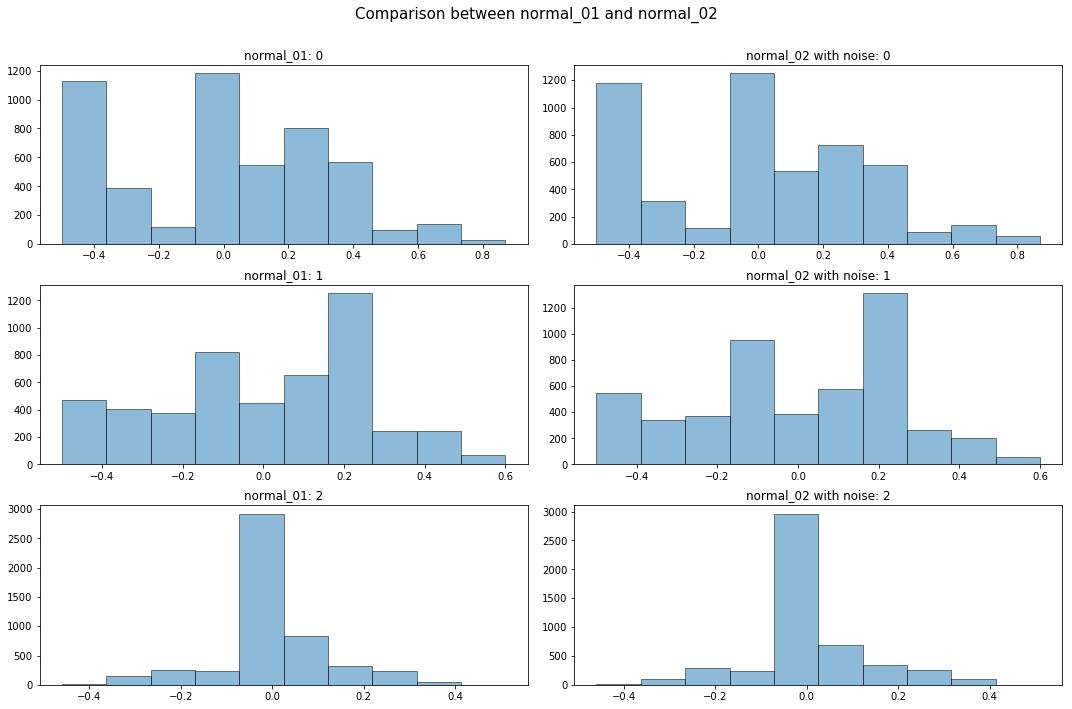

In [174]:
def VisCompareTwoPCA(pca_data_1, pca_data_2, PCA_process_obj, data_name_1, data_name_2):
    '''two compressed pca_data, the object used to process the data, two data names for plot'''
    fig = plt.figure(figsize=(15,10))
    for plt_idx in range(pca_data_1.shape[1]):
        cur_plt_range = PCA_process_obj.component_range
        plt.subplot(3,2,2*plt_idx+1)
        plt.title(data_name_1 + ': ' + str(plt_idx))
        plt.hist(pca_data_1[:,plt_idx], alpha=0.5, ec = 'black', range= [cur_plt_range[0][plt_idx], cur_plt_range[1][plt_idx]] )
        plt.subplot(3,2, 2*plt_idx+2)
        plt.title(data_name_2 + ' with noise: ' + str(plt_idx))
        plt.hist(pca_data_2[:,plt_idx], alpha = 0.5, ec = 'black', range= [cur_plt_range[0][plt_idx], cur_plt_range[1][plt_idx]])
    plt.suptitle('Comparison between ' + data_name_1 + ' and ' +  data_name_2, fontsize = 15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)

VisCompareTwoPCA(test_in, test_in_2, PCA_all, test_case_name, test_case_2_name)

In [162]:
# train the GMM model 
test_gau = GaussianMixture(n_components=4, init_params='kmeans')
test_gau.fit(test_feature_mat.T)
pred_result = test_gau.predict_proba(test_feature_mat.T)
# the model on the training data
# for idx in range(len(actual_label)):
#     print(gait_names[int(actual_label[idx])] + ': ' + str(pred_result[idx]*100)) 
# print('--------------------------')
print('GMM')
print(test_gau.predict_proba([test_fea]))

# Test if logistc regrisson works 
test_log = linear_model.LogisticRegression()
test_log.fit(test_feature_mat.T, actual_label)
print('Log')
print(test_log.predict_proba([test_fea]))
print(test_log.predict_proba([test_fea_2]))

# Support vector machine  
test_svc = NuSVC(probability=True)
test_svc.fit(test_feature_mat.T, actual_label)
print('SVM')
print(test_svc.predict_proba([test_fea]))
print(test_svc.predict_proba([test_fea_2]))

# Adaboost
test_ada = ensemble.AdaBoostClassifier()
test_ada.fit(test_feature_mat.T, actual_label)
print('Ada')
print(test_ada.predict_proba([test_fea]))
print(test_ada.predict_proba([test_fea_2]))

GMM
[[ 0.  1.  0.  0.]]
Log
[[ 0.82150945  0.03060957  0.03690596  0.11097503]]
[[ 0.03049735  0.34210763  0.53222536  0.09516965]]
SVM
[[ 0.98383325  0.00238527  0.00363324  0.01014825]]
[[ 0.00275427  0.07825579  0.91270317  0.00628677]]
Ada
[[  9.99973608e-01   2.59690867e-05   4.22998191e-07   1.01291808e-10]]
[[  4.30066837e-10   3.78471171e-04   9.99621527e-01   1.65098061e-09]]


In [180]:
def FFTFeature(pca_data, in_time):
    for idx in range(pca_data.shape[1]):
        cur_data = pca_data[:,idx]
        # fft to find the major frequency for the current data 
        sample_freq = np.mean(1/(np.diff(in_time)))
        sample_period = 1/sample_freq
        sig_len = len(cur_data)
        fft_result = np.fft.fft(cur_data)
        sig_fft = np.abs(fft_result/sig_len)
        
        # plot fft freq result 
        hf_len = int(sig_len/2) 
        fft_y = sig_fft[1:hf_len + 1]
        fft_y[1:-1] = 2 * fft_y[1:-1]
        freq_x = sample_freq * range(0,hf_len)/sig_len
        plt.figure(figsize= (15, 5))
        print(fft_y)
         
        idx_xs = find_peaks_cwt(fft_y[freq_x < 10], np.arange(0.1, 1, 0.2))
        
        plt.subplot(121)
        plt.plot(freq_x[idx_xs], fft_y[idx_xs], 'ro')
        plt.plot(freq_x, fft_y)
        plt.subplot(122)
        plt.hist(fft_y[idx_xs], bins = 10, ec = 'black')
        print(np.histogram(fft_y[idx_xs], bins = 10))
        return None

In [181]:
np.arange(1,15)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

[  3.03535138e-03   2.23240993e-03   2.75059652e-03 ...,   8.45622302e-05
   5.17954770e-04   4.81471838e-05]
(array([108,   5,   3,   3,   0,   0,   0,   0,   2,   2], dtype=int64), array([ 0.00200736,  0.02113388,  0.0402604 ,  0.05938692,  0.07851344,
        0.09763996,  0.11676648,  0.135893  ,  0.15501952,  0.17414605,
        0.19327257]))


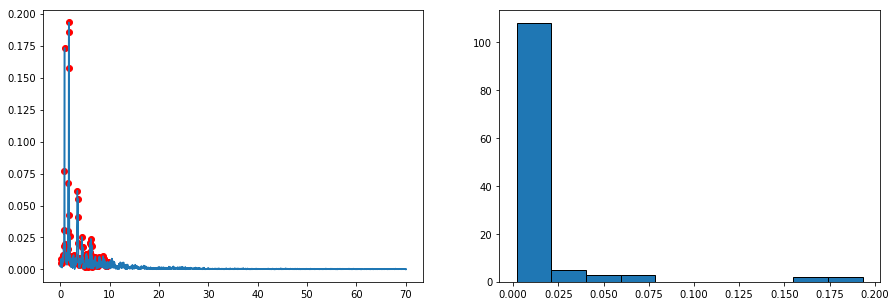

In [182]:
FFTFeature(test_in_2, test_case_2['Time'])

In [159]:
# find the peaks and see if the recreaed wave match with the input 
peaks_idx = find_peaks_cwt(fft_y[:2000], [1])
plt.figure()
plt.plot(freq_x[peaks_idx], fft_y[peaks_idx], 'bo')
plt.figure(figsize=(12,5))
plt.hist(fft_y[peaks_idx], rwidth=0.8)
# try the two freq 

NameError: name 'fft_y' is not defined

In [425]:
print(np.percentile(fft_y,99.9))

1.04597826012


In [378]:
print(1/(np.diff(test_data['Time'])))

[ 142.85714286  142.85714286  125.         ...,  125.          142.85714286
  142.85714286]


In [285]:
# feature engineering 
# hog like bin?
# add max angle or vel?
